In [1]:
!pip install openpyxl #for loading xlsx files using pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 1.4 MB/s eta 0:00:00


## Importing Necessary Libraries

In [2]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
from sklearn import metrics
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

src = ".."
device = "cuda:0"


#### Loading generated dataframe for Train and Valid set

In [3]:
Train = pd.read_excel("{}/Train.xlsx".format(src))
Valid = pd.read_excel("{}/Valid.xlsx".format(src))

In [4]:
Train.head()

,ID,Path,Modality,Vocal Channel,Emotion,Emotional intensity,Statement,Repetition,Actor
0,01-01-01-01-01-01-01,audio-video/Actor_01/01-01-01-01-01-01-01.mp4,full-AV,speech,neutral,normal,Kids are talking by the door,1st repetition,1
1,01-01-01-01-01-02-01,audio-video/Actor_01/01-01-01-01-01-02-01.mp4,full-AV,speech,neutral,normal,Kids are talking by the door,2nd repetition,1
2,01-01-01-01-02-01-01,audio-video/Actor_01/01-01-01-01-02-01-01.mp4,full-AV,speech,neutral,normal,Dogs are sitting by the door,1st repetition,1
3,01-01-01-01-02-02-01,audio-video/Actor_01/01-01-01-01-02-02-01.mp4,full-AV,speech,neutral,normal,Dogs are sitting by the door,2nd repetition,1
4,01-01-02-01-01-01-01,audio-video/Actor_01/01-01-02-01-01-01-01.mp4,full-AV,speech,calm,normal,Kids are talking by the door,1st repetition,1


In [5]:
emotion = {
    "neutral": 0, 
    "calm": 1, 
    "happy": 2, 
    "sad": 3, 
    "angry": 4, 
    "fearful": 5, 
    "disgust": 6, 
    "surprised": 7
}

reverse_emotion = {y: x for x, y in emotion.items()}

## Initializing custom Dataset class

#### We load audio files of wav format and use the resampling transform

In [6]:
class myDataset(Dataset):
    def __init__(self, df, path, emotion, transform):
        self.df = df
        self.path = path
        self.emotion = emotion
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        file = "{}/{}.wav".format(self.path, self.df["ID"].iloc[idx])
        waveform, sample_rate = torchaudio.load(file, normalize=True)        
        transformed = self.transform(waveform)
        label = torch.tensor(self.emotion[self.df["Emotion"].iloc[idx]])
        
        return transformed, label

#### Since the audios vary in duration, the tensors they will generate will also not be equal in length. Therefore we use a collate function to pad the tensors into become of equal size

In [7]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [8]:
transform = torchaudio.transforms.Resample(new_freq=8000)

src = "../audio-wav"
trainset = myDataset(Train, src, emotion, transform)
validset = myDataset(Valid, src, emotion, transform)

trainloader = DataLoader(trainset, batch_size=4, collate_fn=collate_fn, shuffle=True)
validloader = DataLoader(validset, batch_size=2, collate_fn=collate_fn, shuffle=False)


In [9]:
image, label = next(iter(trainloader))
print(image.shape, label.shape)


torch.Size([4, 2, 85554]) torch.Size([4])


## Initializing custom Model class

#### We used a model with four 1D CNN layers for the tensors converted from audio waveform. It also have four maxpooling operations to downsample the tensor, along with batchnorm for faster learning. 

In [10]:
class CNN(nn.Module):
    def __init__(self, n_input=2, num_classes=8, stride=16, n_channel=32):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(n_channel, n_channel, kernel_size=3),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3),
            nn.BatchNorm1d(2 * n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3),
            nn.BatchNorm1d(2 * n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        self.fc = nn.Linear(2 * n_channel, num_classes)
              
    def forward(self, x):
        out = self.model(x)
        out = F.avg_pool1d(out, out.shape[-1])
        out = out.permute(0, 2, 1)
        out = self.fc(out).squeeze(1)
        return out

## Defining configuration for training

In [11]:
config = {  
    "epochs": 20,
    "path2weights": "best.pt",
    "num_classes": len(emotion.keys()),
    "dropout": 0.1,
    "pretrained" : True,
    "trainloader": trainloader,
    "validloader": validloader,
    "sanity_check": False,
}

## Defining functions for training model

In [12]:
def trainModel(model, criterion, optimizer, scheduler, config):
    epochs=config["epochs"]
    trainloader=config["trainloader"]
    validloader=config["validloader"]
    sanity_check=config["sanity_check"]
    path2weights=config["path2weights"]
   
    #for plotting    
    loss_history={
        "train": [],
        "val": [],
    }

    #for plotting    
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(epochs):
        current_lr=get_lr(optimizer)
        print('Epoch {}/{}, current lr = {}'.format(epoch, epochs-1, current_lr))
        model.train() #for training
        train_loss, train_metric = oneEpoch(model, criterion, trainloader, sanity_check, optimizer) #one training epoch
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval() #for validation
        with torch.no_grad():
            val_loss, val_metric = oneEpoch(model, criterion, validloader, sanity_check) #one validation epoch
        #saving weights from best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        #updating learning rate scheduler
        scheduler.step(val_loss)
        if current_lr != get_lr(optimizer):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        

        print("Train Loss: %.6f, Val Loss: %.6f, Val Acc: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 
    #reloading best weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history


# get learning rate 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#get metrics for a batch
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True) #picking highest probability index
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

#performing backward propagation
def loss_batch(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), metric_b
    
#iterating through all batches in a given epoch
def oneEpoch(model, criterion, dataloader, sanity_check=False, optimizer=None):
    running_loss, running_metric = 0.0, 0.0
    len_data = len(dataloader.dataset)
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) #shifting data to gpu from cpu
        output = model(inputs)
        loss_b, metric_b = loss_batch(criterion, output, labels, optimizer)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

## Starting training

In [13]:
model = CNN(num_classes=config["num_classes"]) #instantiating model
model.to(device) #shifting model to gpu from cpu
criterion = nn.CrossEntropyLoss(reduction="sum") #loss function
optimizer = optim.Adam(model.parameters(), lr=3e-4) #optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,verbose=1) #learning rate scheduler
model, loss_history, metric_history = trainModel(model, criterion, optimizer, scheduler, config)

Epoch 0/19, current lr = 0.0003
Copied best model weights!
Train Loss: 1.966954, Val Loss: 1.851442, Val Acc: 33.33
----------
Epoch 1/19, current lr = 0.0003
Copied best model weights!
Train Loss: 1.892406, Val Loss: 1.786822, Val Acc: 40.42
----------
Epoch 2/19, current lr = 0.0003
Train Loss: 1.866511, Val Loss: 1.792220, Val Acc: 38.75
----------
Epoch 3/19, current lr = 0.0003
Copied best model weights!
Train Loss: 1.843683, Val Loss: 1.739889, Val Acc: 35.42
----------
Epoch 4/19, current lr = 0.0003
Copied best model weights!
Train Loss: 1.792034, Val Loss: 1.678897, Val Acc: 44.58
----------
Epoch 5/19, current lr = 0.0003
Train Loss: 1.770233, Val Loss: 1.738702, Val Acc: 35.42
----------
Epoch 6/19, current lr = 0.0003
Copied best model weights!
Train Loss: 1.732822, Val Loss: 1.635834, Val Acc: 40.83
----------
Epoch 7/19, current lr = 0.0003
Copied best model weights!
Train Loss: 1.693418, Val Loss: 1.578847, Val Acc: 39.58
----------
Epoch 8/19, current lr = 0.0003
Train 

## Plotting Graphs

In [14]:
def plot_loss(loss_hist, metric_hist):

    epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1, epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1, epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1, epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1, epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

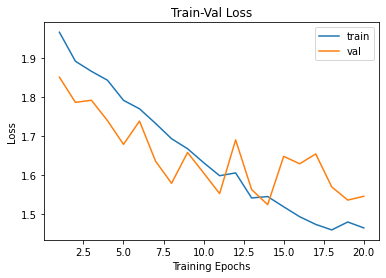

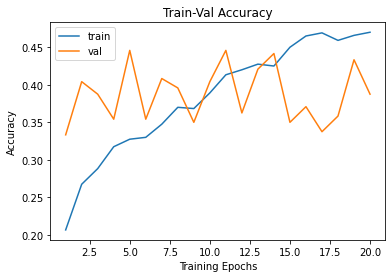

In [15]:
plot_loss(loss_history, metric_history)

#### Confusion Matrix and Classification Report (Precision, Recall, F1-Score) for Validation Set

In [16]:
src = "../input/emotionaudio/audio-wav/audio-wav"
testset = myDataset(Valid, src, emotion, transform)
testloader = DataLoader(testset, batch_size=2, collate_fn=collate_fn, shuffle=False)

lbl_list, out_list = [], []
for inputs, labels in tqdm(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs).argmax(dim=1, keepdim=True)
    lbl_list.extend(labels)
    out_list.extend(output)

pred = [reverse_emotion[x.item()] for x in out_list]
true = [reverse_emotion[x.item()] for x in lbl_list]

print("CONFUSION MATRIX\n")
print(metrics.confusion_matrix(true, pred))
print("\n\nCLASSIFICATION REPORT\n")
print(metrics.classification_report(true, pred, digits=3));

100%|██████████| 120/120 [00:01<00:00, 83.33it/s]

CONFUSION MATRIX

[[16  0  0  7  3  0  3  3]
 [ 0 28  1  0  0  0  3  0]
 [ 7  1 12  1  0  0  9  2]
 [ 2  0  0 15  0  0  6  9]
 [ 2  0  0  9  2  0  9 10]
 [ 0  4  1  2  0  0  6  3]
 [ 0 11  2  4  0  0 14  1]
 [ 1  0  0  9  0  0  3 19]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

       angry      0.571     0.500     0.533        32
        calm      0.636     0.875     0.737        32
     disgust      0.750     0.375     0.500        32
     fearful      0.319     0.469     0.380        32
       happy      0.400     0.062     0.108        32
     neutral      0.000     0.000     0.000        16
         sad      0.264     0.438     0.329        32
   surprised      0.404     0.594     0.481        32

    accuracy                          0.442       240
   macro avg      0.418     0.414     0.384       240
weighted avg      0.446     0.442     0.409       240



#### Confusion Matrix and Classification Report (Precision, Recall, F1-Score) for Validation Set with respect to each sentence

In [17]:
statements = ["Kids are talking by the door", "Dogs are sitting by the door"]

for statement in statements: 
    Test = Valid[Valid["Statement"] == statement]
    testset = myDataset(Test, src, emotion, transform)
    testloader = DataLoader(testset, batch_size=2, collate_fn=collate_fn, shuffle=False)

    lbl_list, out_list = [], []
    for inputs, labels in tqdm(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs).argmax(dim=1, keepdim=True)
        lbl_list.extend(labels)
        out_list.extend(output)

    pred = [reverse_emotion[x.item()] for x in out_list]
    true = [reverse_emotion[x.item()] for x in lbl_list]

    print("CONFUSION MATRIX for '{}'\n".format(statement))
    print(metrics.confusion_matrix(true, pred))
    print("\n\nCLASSIFICATION REPORT for '{}'\n".format(statement))
    print(metrics.classification_report(true, pred, digits=3));
    print("\n\n")

100%|██████████| 60/60 [00:00<00:00, 91.78it/s]


CONFUSION MATRIX for 'Kids are talking by the door'

[[ 8  0  0  4  2  0  2  0]
 [ 0 14  0  0  0  0  2  0]
 [ 5  0  5  0  0  0  6  0]
 [ 0  0  0  8  0  0  3  5]
 [ 1  0  0  4  2  0  5  4]
 [ 0  2  0  1  0  0  4  1]
 [ 0  7  0  3  0  0  6  0]
 [ 0  0  0  4  0  0  3  9]]


CLASSIFICATION REPORT for 'Kids are talking by the door'

              precision    recall  f1-score   support

       angry      0.571     0.500     0.533        16
        calm      0.609     0.875     0.718        16
     disgust      1.000     0.312     0.476        16
     fearful      0.333     0.500     0.400        16
       happy      0.500     0.125     0.200        16
     neutral      0.000     0.000     0.000         8
         sad      0.194     0.375     0.255        16
   surprised      0.474     0.562     0.514        16

    accuracy                          0.433       120
   macro avg      0.460     0.406     0.387       120
weighted avg      0.491     0.433     0.413       120






100%|██████████| 60/60 [00:00<00:00, 94.01it/s]

CONFUSION MATRIX for 'Dogs are sitting by the door'

[[ 8  0  0  3  1  0  1  3]
 [ 0 14  1  0  0  0  1  0]
 [ 2  1  7  1  0  0  3  2]
 [ 2  0  0  7  0  0  3  4]
 [ 1  0  0  5  0  0  4  6]
 [ 0  2  1  1  0  0  2  2]
 [ 0  4  2  1  0  0  8  1]
 [ 1  0  0  5  0  0  0 10]]


CLASSIFICATION REPORT for 'Dogs are sitting by the door'

              precision    recall  f1-score   support

       angry      0.571     0.500     0.533        16
        calm      0.667     0.875     0.757        16
     disgust      0.636     0.438     0.519        16
     fearful      0.304     0.438     0.359        16
       happy      0.000     0.000     0.000        16
     neutral      0.000     0.000     0.000         8
         sad      0.364     0.500     0.421        16
   surprised      0.357     0.625     0.455        16

    accuracy                          0.450       120
   macro avg      0.362     0.422     0.380       120
weighted avg      0.387     0.450     0.406       120




